In [2]:
!pip install lyft_dataset_sdk --user


  Using cached https://files.pythonhosted.org/packages/52/d0/1203423cd24ae9da33a66736a75ee81f7f7e487dde5041b99a66f86a444d/lyft_dataset_sdk-0.0.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/97/36/1af447160f713d72f35dd7e749788367b7a13285c4af2fbd675128aa4e99/Shapely-1.6.4.post2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/30/62/cf549544a5fe990bbaeca21e9c419501b2de7a701ab0afb377bc81676600/black-19.3b0-py36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2f/a6/30b0a0bef12283e83e58c1d6e7b5aabc7acfc4110df81a4471655d33e704/cachetools-3.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/69/faeaae8687f4de0f5973694d02e9d6c3eb827636a009157352d98de1129e/fire-0.2.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/0c/91/d68f68ce54cd3e8afa1ef73ea1ad44df2438521b64c0820e5fd9b9f13b7d/pytest-5.2.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages

In [1]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

In [4]:
!pip install seaborn --user

     |████████████████████████████████| 215kB 397kB/s eta 0:00:01


In [5]:
!ls -la

total 28
drwxr-xr-x 3 alin1 alin1  4096 17:12  7 Thg 10 .
drwxr-xr-x 8 alin1 alin1  4096 17:06  7 Thg 10 ..
drwxr-xr-x 2 alin1 alin1  4096 17:06  7 Thg 10 .ipynb_checkpoints
-rw-r--r-- 1 alin1 alin1 15077 17:12  7 Thg 10 Untitled.ipynb


In [10]:
DATA_PATH = '../input/'


In [11]:
train = pd.read_csv(DATA_PATH + 'train.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [12]:
# Taken from https://www.kaggle.com/gaborfodor/eda-3d-object-detection-challenge

object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:04<00:00, 4946.99it/s]


In [13]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [14]:
train_objects.head()


,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2.0,2713.607422,694.403503,-18.589972,1.779,4.992,1.620,2.579456,car
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,3.0,2679.986816,706.910156,-18.349594,1.798,3.903,1.722,2.586166,car
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,4.0,2659.352051,719.417480,-18.442999,1.936,4.427,1.921,2.601799,car


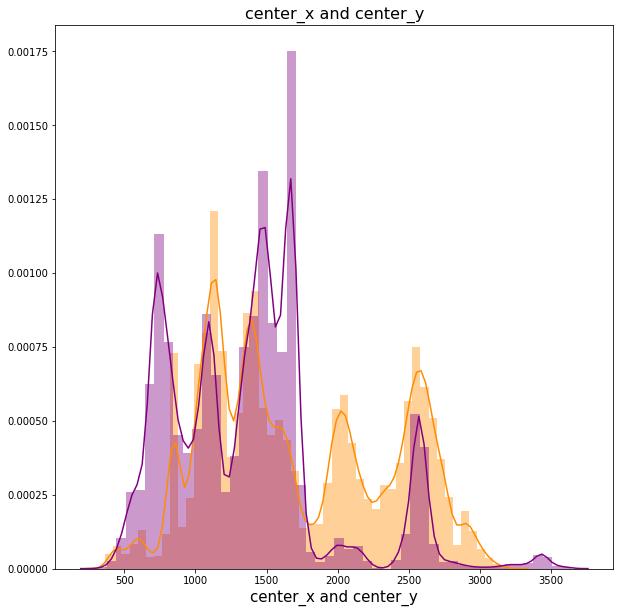

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_x'], color='darkorange', ax=ax).set_title('center_x and center_y', fontsize=16)
sns.distplot(train_objects['center_y'], color='purple', ax=ax).set_title('center_x and center_y', fontsize=16)
plt.xlabel('center_x and center_y', fontsize=15)
plt.show()

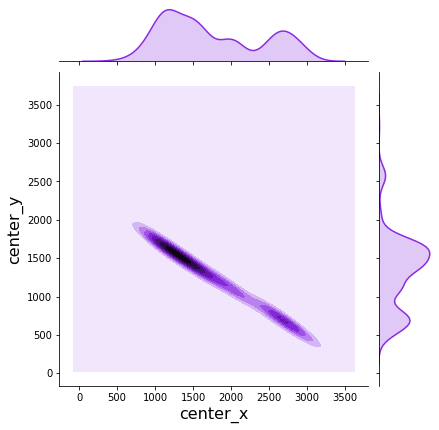

In [16]:
new_train_objects = train_objects.query('class_name == "car"')
plot = sns.jointplot(x=new_train_objects['center_x'][:1000], y=new_train_objects['center_y'][:1000], kind='kde', color='blueviolet')
plot.set_axis_labels('center_x', 'center_y', fontsize=16)
plt.show()

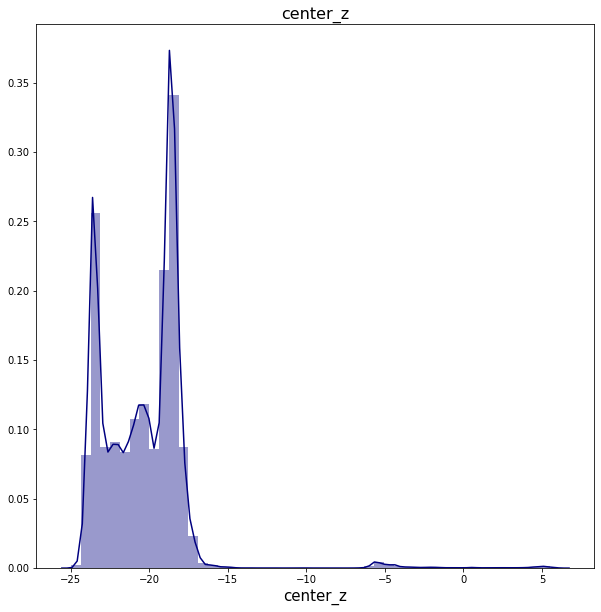

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_z'], color='navy', ax=ax).set_title('center_z', fontsize=16)
plt.xlabel('center_z', fontsize=15)
plt.show()

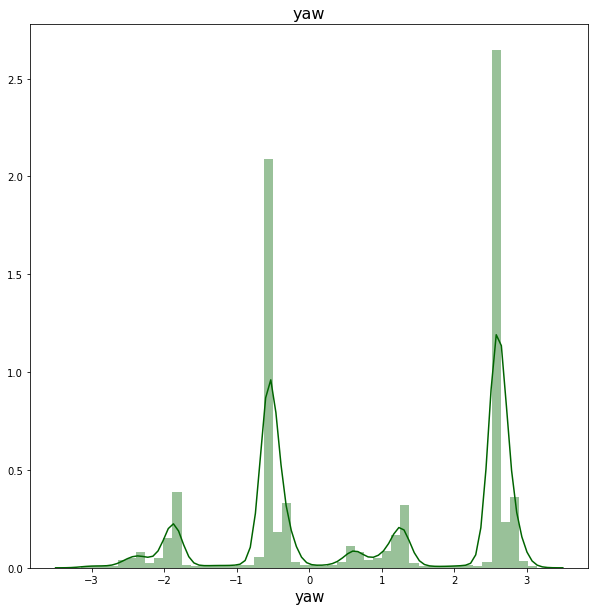

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['yaw'], color='darkgreen', ax=ax).set_title('yaw', fontsize=16)
plt.xlabel('yaw', fontsize=15)
plt.show()

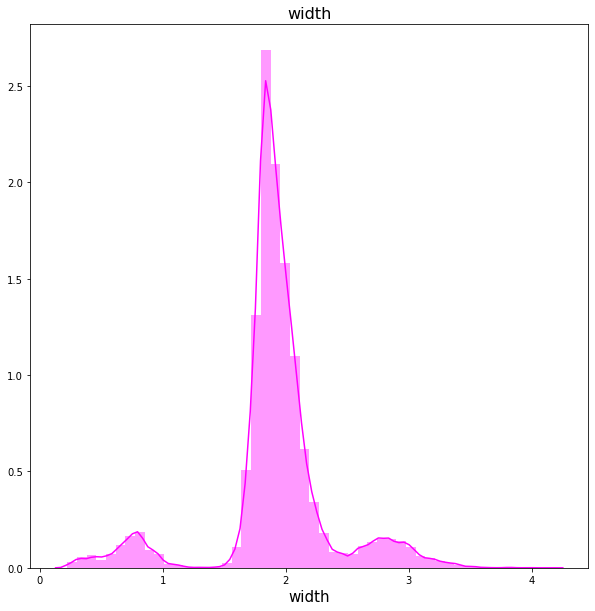

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['width'], color='magenta', ax=ax).set_title('width', fontsize=16)
plt.xlabel('width', fontsize=15)
plt.show()